
# TP : Modèles de Diffusion 

*Auteur: HANNOUNI SALMA*

## **Objectifs pédagogiques du TP**

À la fin de ce TP, l’étudiant sera capable de :

- Visualiser le processus de diffusion en avant

- Comprendre le principe de la diffusion en arrière

- Relier diffusion et génération d’images

- Expérimenter la génération d’images à partir de texte

- Comparer les différentes étapes du processus

## **I. Introduction Conceptuelle**

Un Diffusion Model est un modèle génératif qui apprend à créer des données (images, audio, vidéo) en inversant un processus de bruitage progressif.

Il repose sur deux processus complémentaires :

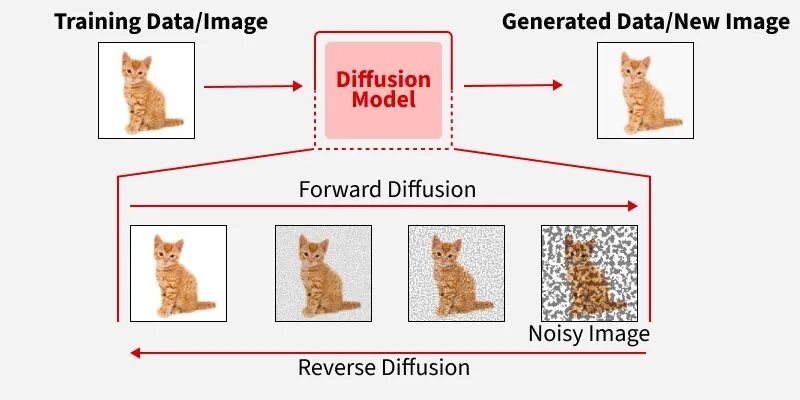

### **1. Processus de diffusion forward (bruitage)**

Le **forward process** consiste à transformer progressivement une donnée réelle $x_0$ en bruit gaussien.

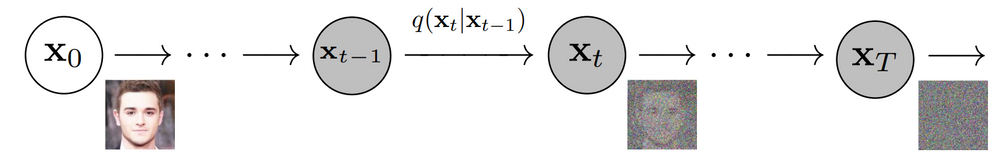

À chaque étape $t$, on ajoute un petit bruit :

$x_t = \sqrt{1-\beta_t} x_{t-1} + \sqrt{\beta_t}\epsilon \qquad \epsilon \sim \mathcal{N}(0, I)$

* $x_{t-1}$ : donnée précédente
* $x_t$ : donnée bruitée
* $\beta_t$ : quantité de bruit ajoutée à l’étape $t$

Quand $t$ augmente :

* l’information de $x_0$ diminue
* le bruit augmente
* à $t=T$, $x_T$ ≈ bruit gaussien pur

Pour l’implémentation, on utilise souvent la forme équivalente suivante :

$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$

avec $\bar{\alpha}_t = \prod_{i=1}^{t} (1-\beta_i)$.


Il existe plusieurs stratégies pour définir $\beta_t$, appelées **noise schedules**.
Dans ce TP, nous présentons trois schémas couramment utilisés.

---

#### Schéma à $\beta$ constant (Constant Schedule)

$\beta_1 = \beta_2 = \dots = \beta_T = \beta$

La même quantité de bruit est ajoutée à chaque étape.


#### Schéma linéaire (Linear Schedule)

$\beta_t = \beta_{\text{start}} +
\frac{t-1}{T-1}
(\beta_{\text{end}} - \beta_{\text{start}})$

Le bruit augmente progressivement avec le temps.

#### Schéma cosine (Cosine Schedule)

Contrairement aux autres schémas, le cosine schedule **ne définit pas directement $\beta_t$**.
Il contrôle d’abord la décroissance de l’information restante $\bar{\alpha}_t$.

$\bar{\alpha}_t =
\cos^2\left(
\frac{t/T + s}{1+s}\cdot \frac{\pi}{2}
\right)$

avec :

* (T) : nombre total d’étapes
* (s) : paramètre de lissage (souvent (s = 0.008))

Puis :
$
\alpha_t = \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}},
\quad
\beta_t = 1 - \alpha_t
$

**Interprétation intuitive**

| t |  s = 0  |  s = 0.008  |
| - | --------- | ------------- |
| 0 | 1.00      | 0.9998        |
| 1 | 0.85      | **0.96**      |
| 2 | 0.50      | **0.85**      |
| 3 | 0.15      | **0.69**      |
| 4 | 0.00      | **0.50**      |



---

### **2. Processus reverse (débruitage)**

Le **processus reverse** consiste à reconstruire progressivement la donnée originale à partir du bruit.

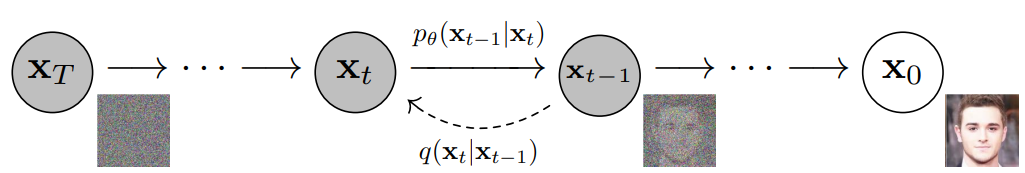

On part d’un bruit gaussien pur $x_T$ et on applique une suite d’étapes : $x_T \rightarrow x_{T-1} \rightarrow \dots \rightarrow x_0$

Contrairement au forward process, le reverse process est **appris** à l’aide d’un **réseau de neurones**.

À chaque étape $t$, le modèle apprend : $p_\theta(x_{t-1} \mid x_t)$

En pratique, le réseau prédit le **bruit** $\epsilon_\theta(x_t, t)$, et la mise à jour est :

$x_{t-1} =
\frac{1}{\sqrt{1-\beta_t}}
\left(
x_t -
\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}
\epsilon_\theta(x_t, t)
\right)$

Quand $t$ diminue :

* le bruit diminue
* l’information utile augmente
* à (t=1), on obtient $x_0$

---

## II. Implémentation

### **1. Importation des bibliothèques et configuration**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### **2. Chargement du dataset MNIST**

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.89MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.55MB/s]


### **3. Charger un batch et l’afficher**

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([6, 9, 6, 8, 2, 3, 8, 9, 4, 3, 6, 3, 6, 4, 6, 7, 9, 8, 8, 9, 5, 3, 7, 2,
        6, 0, 2, 8, 0, 3, 1, 7, 8, 3, 7, 4, 6, 1, 6, 5, 5, 6, 2, 9, 0, 9, 5, 0,
        1, 2, 3, 7, 3, 5, 2, 1, 0, 9, 3, 7, 1, 3, 7, 3])


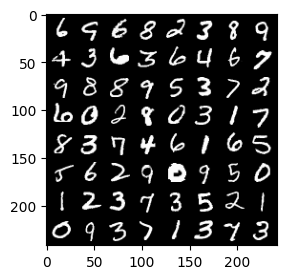

In [3]:
from torch.utils.data import DataLoader

# 1) DataLoader = lit MNIST par mini-lots (batch)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)

plt.figure(figsize=(10,3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1,2,0).numpy())
plt.show()

### **4. Scheduler de diffusion (DDPM)**

Le scheduler DDPM contrôle l’intensité du bruit ajouté à chaque étape de diffusion et permet ensuite de retirer ce bruit progressivement lors de la génération.

In [4]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(scheduler)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.36.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



**Explication :**

- Le scheduler définit comment le bruit est ajouté et retiré.

- num_train_timesteps=1000 → la diffusion se fait en 1000 étapes.

- beta_start → petite quantité de bruit au début.

- beta_end → beaucoup de bruit à la fin.

- scaled_linear → bruit augmente progressivement et de façon stable.

### **5. Forward Diffusion : ajout progressif du bruit**

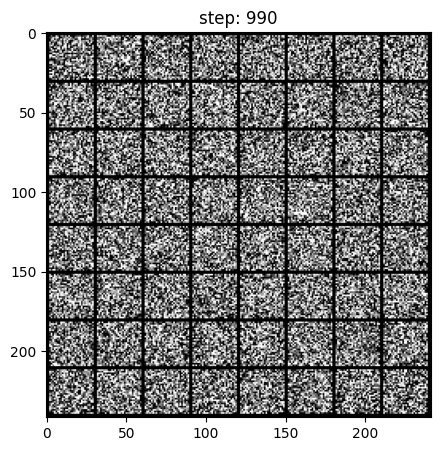

In [6]:
for t in range(scheduler.num_train_timesteps):

    # 1) générer du bruit gaussien
    noise = torch.randn_like(x) #Epsilon même taille que x

    # 2) ajouter le bruit à l’image à l’étape t
    x_noised = scheduler.add_noise(x, noise, torch.tensor(t).long())

    # 3) visualiser quelques étapes
    if t % 10 == 0:
        plt.figure(figsize=(5,5))
        plt.title(f"step: {t}")
        plt.imshow(torchvision.utils.make_grid(x_noised * 0.5 + 0.5).permute(1,2,0).cpu().numpy()) #les images sont normalisées [−1,1]
        plt.axis("off")
        clear_output(wait=True)
        plt.show()


**Explication :**

- À chaque étape t, on ajoute un peu plus de bruit aux images.

- scheduler.add_noise() applique exactement la formule du forward diffusion.

- Quand t augmente → l’image disparaît progressivement.

- À la fin (t ≈ 1000) → bruit quasi pur.

### **6. Modèle UNet conditionné**

In [7]:
# Ce UNet est conçu pour prédire le bruit dans les modèles de diffusion
from diffusers import UNet2DModel

# Définition du UNet conditionné (temps + classe)
unet = UNet2DModel(
    # Taille des images d'entrée (MNIST = 28x28)
    sample_size=28,
    
    # Nombre de canaux en entrée :
    in_channels=1,
    
    # le modèle prédit le bruit, de même dimension que l'image
    out_channels=1,
    
    # Nombre de couches ResNet par bloc du UNet
    # Plus ce nombre est élevé, plus le modèle est profond
    layers_per_block=2,
    
    # Le timestep t est transformé en un vecteur de taille 128
    time_embedding_dim=128,
    
    # Blocs de l'encodeur (descente)
    # Les blocs "Attn" ajoutent de la self-attention pour capturer
    # la structure globale de l'image
    down_block_types=(
        'DownBlock2D',       # Convolutions + downsampling
        'DownBlock2D',
        'AttnDownBlock2D'    # Downsampling + self-attention
    ),
    
    # Bloc central (bottleneck du UNet)
    # Combine information globale + temps + classe
    mid_block_type='UNetMidBlock2D',
    
    # Blocs du décodeur (remontée)
    # Reconstruit l'image à partir des features compressées
    up_block_types=(
        'AttnUpBlock2D',     # Upsampling + attention
        'UpBlock2D',
        'UpBlock2D'
    ),
    
    # Nombre de canaux de sortie pour chaque niveau du UNet
    block_out_channels=(32, 32, 64),
    
    # Type d'embedding pour la classe
    # 'timestep' signifie que l'embedding de la classe est ajouté
    # à l'embedding du timestep
    class_embed_type='timestep',
    
    # Nombre de classes (MNIST = chiffres de 0 à 9)
    num_class_embeds=10,
)


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


**Explication :**

- UNet prédit le bruit ajouté à chaque étape.

- Entrée : image bruitée + timestep + label (0–9).

- Sortie : bruit estimé (même taille que l’image).

- L’attention aide le modèle à capturer la structure globale du chiffre.

- num_class_embeds=10 → génération conditionnée par classe.

In [8]:
# Nombre total de paramètres du UNet
print(f'Number of parameters in the model: {sum(p.numel() for p in unet.parameters())}')

Number of parameters in the model: 1188801


In [9]:
# Envoyer le modèle sur CPU ou GPU
unet.to(device)

# Créer des images bruitées (batch de 5 images MNIST)
x = torch.randn(5, 1, 28, 28).to(device)

# Définir les timesteps de diffusion
t = torch.linspace(0, 999, 5).long().to(device) #exemple t = [0, 249, 499, 749, 999]

#Génère une permutation aléatoire des labels
cls = torch.randperm(5).long().to(device) 

# Passage avant sans calcul des gradients
with torch.no_grad():
    # Le UNet prédit le bruit à partir de l’image, du temps et de la classe
    output = unet(x, t, cls)

# Vérifier la taille de la sortie (identique à l’entrée)
output.sample.shape


torch.Size([5, 1, 28, 28])

**Explication :**

- On teste le modèle sans l’entraîner.

- Entrée : images bruitées + timestep + classe.

- Sortie : bruit prédit de même taille que l’entrée.

- La forme (5, 1, 28, 28) confirme que le UNet est bien configuré.

### **7.Génération d’images (Reverse Diffusion)**

In [10]:
# 7. Génération d'images (Reverse Diffusion)

def generate_image():
    # 1) Point de départ : bruit pur (10 images)
    xt = torch.randn(10, 1, 28, 28).to(device)
    
    # 2) Labels pour conditionner la génération (chiffres 0 à 9)
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
    
    # 3) Mode évaluation
    unet.eval()
    
    # 4) Boucle de débruitage inverse (1000 étapes)
    for t in tqdm(scheduler.timesteps, total=scheduler.num_train_timesteps, leave=False):
        with torch.no_grad():
            # Prédit le bruit dans l'image
            noise_pred = unet(xt, t, y).sample
        
        # Enlève un peu de bruit à chaque étape
        xt = scheduler.step(noise_pred, t, xt).prev_sample
    
    # 5) Affiche les 10 chiffres générés
    plt.figure(figsize=(10, 3))
    plt.imshow(torchvision.utils.make_grid(xt * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

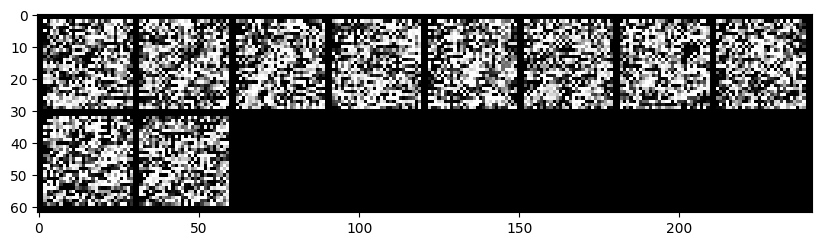

In [11]:
generate_image()

### **8. Entraînement du modèle (Reverse Diffusion Learning)**

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

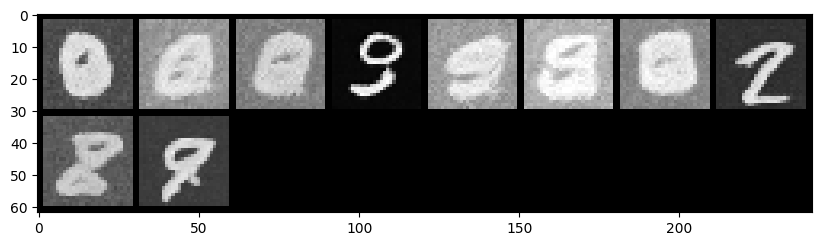

Finished epoch 0. Average of the last 100 loss values: 0.033568


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

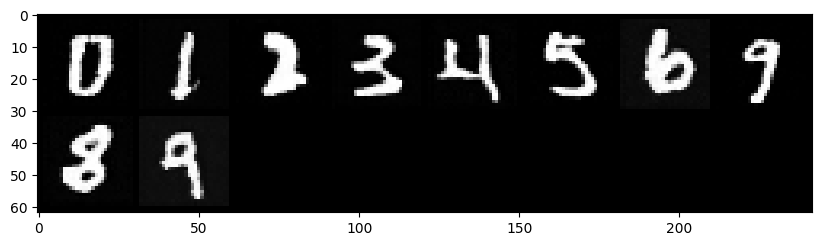

Finished epoch 1. Average of the last 100 loss values: 0.030901


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

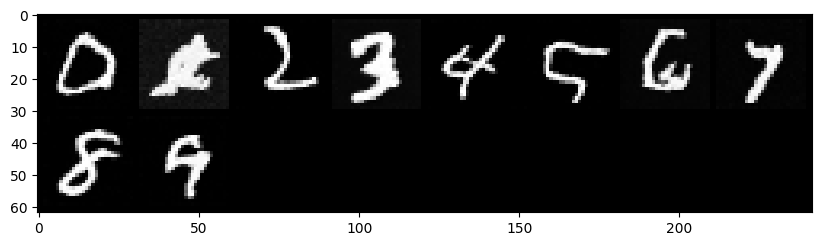

Finished epoch 2. Average of the last 100 loss values: 0.028834


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

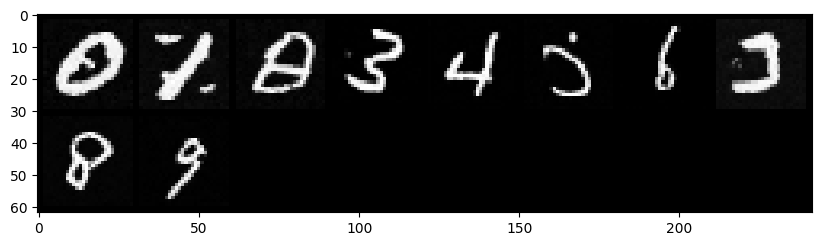

Finished epoch 3. Average of the last 100 loss values: 0.029337


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

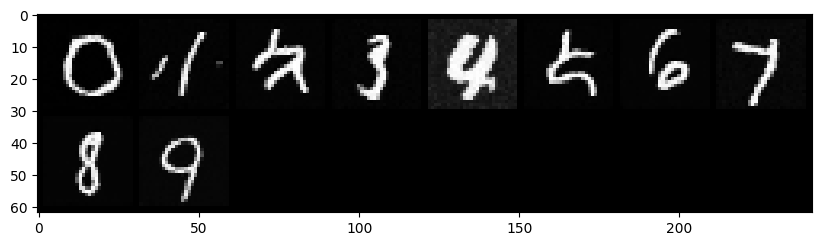

Finished epoch 4. Average of the last 100 loss values: 0.028061


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

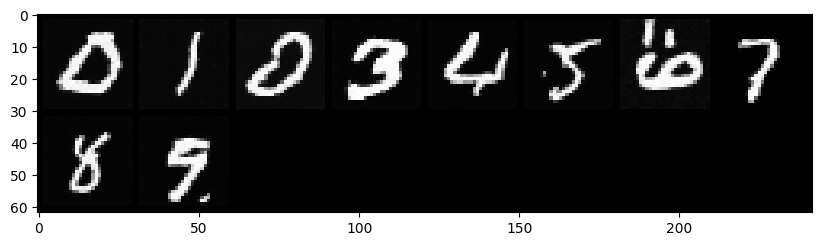

Finished epoch 5. Average of the last 100 loss values: 0.028450


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

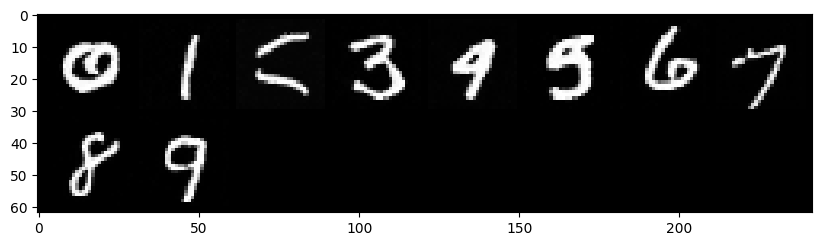

Finished epoch 6. Average of the last 100 loss values: 0.027820


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

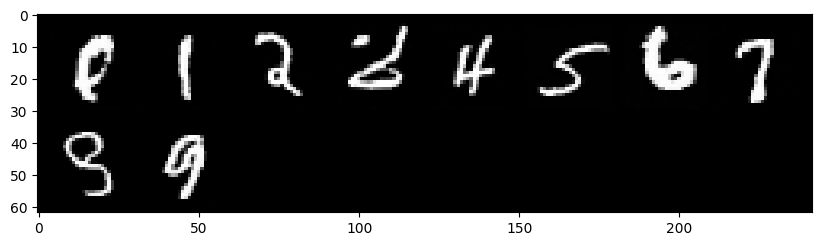

Finished epoch 7. Average of the last 100 loss values: 0.027217


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

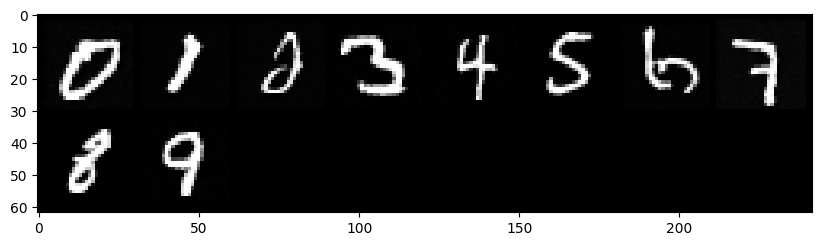

Finished epoch 8. Average of the last 100 loss values: 0.027423


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

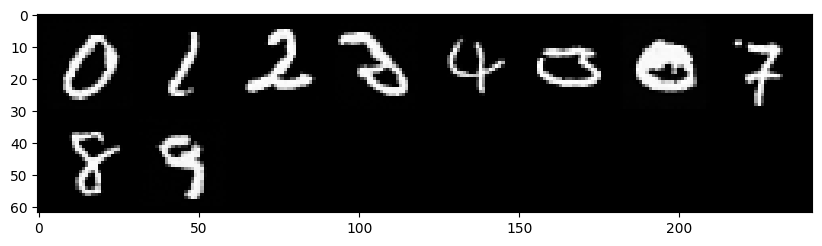

Finished epoch 9. Average of the last 100 loss values: 0.027084


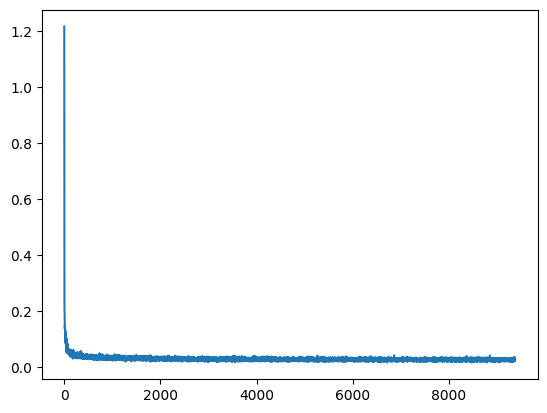

In [12]:
# Nombre d'époques
n_epochs = 10

# Fonction de perte : Erreur Quadratique Moyenne
loss_fn = nn.MSELoss()

# Optimiseur Adam
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)

# Stockage des pertes pour visualisation
losses = []

# Boucle d'entraînement
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        
        # 1) Données sur GPU
        x = x.to(device)  # Images
        y = y.to(device)  # Labels (chiffres 0-9)
        
        # 2) Bruit et timestep aléatoires
        noise = torch.randn_like(x)  # Bruit gaussien
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)  #Modèle apprend à prédire le bruit à n'importe quelle étape
                                                                            #x.shape[0] = nombre d'images dans le batch
        # 3) Ajout de bruit à l'image (forward diffusion)
        noisy_x = scheduler.add_noise(x, noise, timesteps)
        
        # 4) Le UNet prédit le bruit ajouté
        pred = unet(noisy_x, timesteps, y).sample
        
        # 5) Calcul de la perte : différence entre bruit réel et prédit
        loss = loss_fn(pred, noise)
        
        # 6) Rétropropagation
        opt.zero_grad()    # Réinitialise les gradients
        loss.backward()    # Calcule les gradients
        opt.step()         # Met à jour les poids
        
        losses.append(loss.item())
    
    # Génération d'images pour voir la progression
    generate_image()
    
    # Affichage de la perte moyenne sur les 100 derniers batches
    avg_loss = sum(losses[-100:])/100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:.5f}")

# Courbe de la perte
plt.plot(losses)

**Explication :**

- Le modèle apprend à prédire le bruit ajouté à une image.

- À chaque itération :

    1. on ajoute du bruit (forward),

    2. le UNet prédit ce bruit,

    3. on compare bruit réel vs bruit prédit.

- La perte diminue → le modèle apprend à débruiter.

- generate_image() permet de voir l’amélioration visuelle après chaque époque.

### **9. Génération conditionnée final**

  0%|          | 0/1000 [00:00<?, ?it/s]

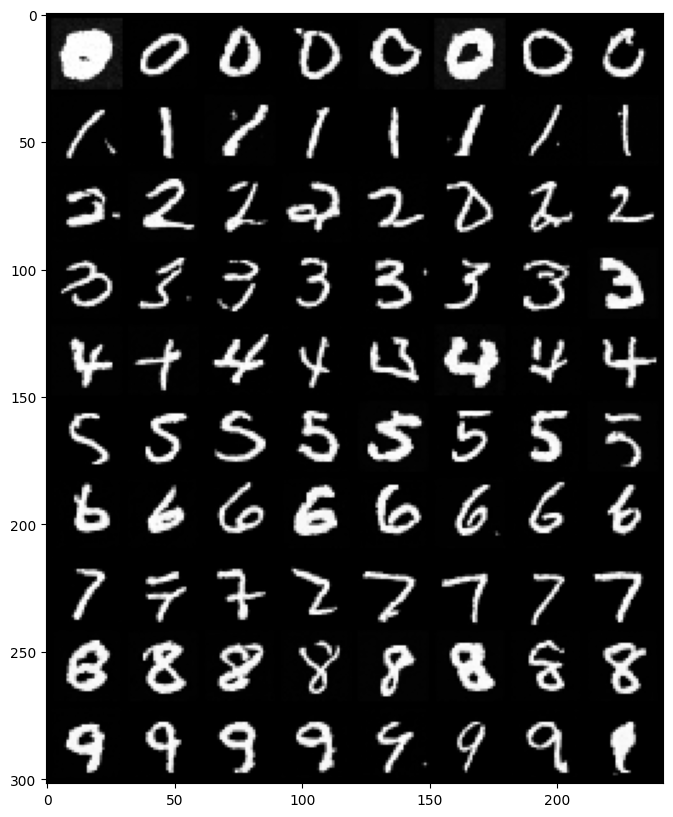

In [13]:
# 1) Bruit initial : 80 images
xt = torch.randn(80,1,28,28).to(device)

# 2) Conditionnement : chaque chiffre répété 8 fois
y =  torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

unet.eval()

# 3) Reverse diffusion complet
for t in tqdm(scheduler.timesteps,total=scheduler.num_train_timesteps,leave=False):
    with torch.no_grad():
        noise_pred = unet(xt,t,y).sample


    xt = scheduler.step(noise_pred, t, xt).prev_sample

# 4) Affichage en grille
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
plt.show()

**Explication :**

- On génère 80 images à partir du bruit pur.

- Le vecteur y impose la classe du chiffre :

  - 8 images pour chaque chiffre de 0 à 9.

- Le modèle applique le reverse diffusion complet.

- Le résultat montre que le modèle :

    - respecte la classe demandée,

    - génère des variations différentes pour une même classe.

### **10. Visualisation du Processus de Diffusion**

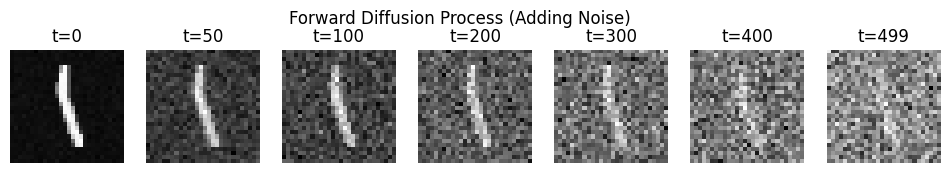

In [19]:
x, y = next(iter(train_dataloader))
x0 = x[0:1].to(device)   # one image

steps = [0, 50, 100, 200, 300, 400, 499]

plt.figure(figsize=(12,2))

for i, t in enumerate(steps):
    noise = torch.randn_like(x0)
    t_tensor = torch.tensor([t]).to(device)

    x_noised = scheduler.add_noise(x0, noise, t_tensor)

    plt.subplot(1, len(steps), i+1)
    plt.imshow((x_noised[0,0]*0.5 + 0.5).cpu(), cmap="gray")
    plt.title(f"t={t}")
    plt.axis("off")

plt.suptitle("Forward Diffusion Process (Adding Noise)")
plt.show()


### **11. Visualisation du Processus de Débruitage (Reverse)**

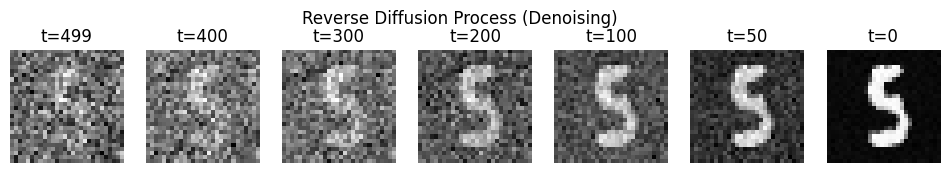

In [21]:
xt = torch.randn(1,1,28,28).to(device)  # pure noise
label = torch.tensor([5]).to(device)    # choose any digit you want

steps = [499, 400, 300, 200, 100, 50, 0]
saved = {}

unet.eval()
with torch.no_grad():
    for t in scheduler.timesteps:
        t_int = int(t)

        if t_int in steps:
            saved[t_int] = xt.clone()

        noise_pred = unet(xt, t, label).sample
        xt = scheduler.step(noise_pred, t, xt).prev_sample

plt.figure(figsize=(12,2))

for i, t in enumerate(steps):
    plt.subplot(1, len(steps), i+1)
    plt.imshow((saved[t][0,0]*0.5 + 0.5).cpu(), cmap="gray")
    plt.title(f"t={t}")
    plt.axis("off")

plt.suptitle("Reverse Diffusion Process (Denoising)")
plt.show()
